In [12]:
# Import necessary libraries
import pandas as pd
model = "gpt-3.5-turbo-1106"

# Load data from CSV file
train_path = f"../data/{model}/train.csv"
test_path = f"../data/{model}/test.csv"
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

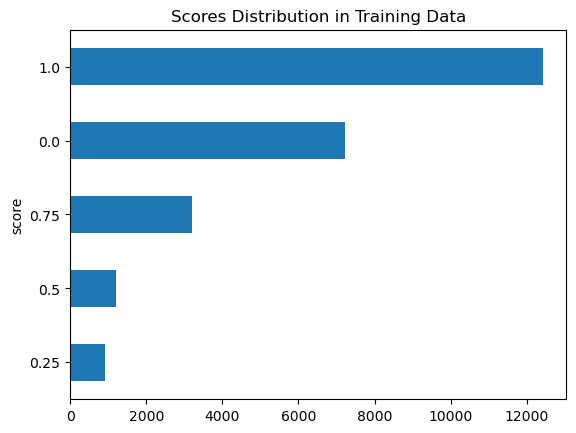

In [13]:
import matplotlib.pyplot as plt

train_df['score'].value_counts(ascending=True).plot.barh()
plt.title('Scores Distribution in Training Data')
plt.show()

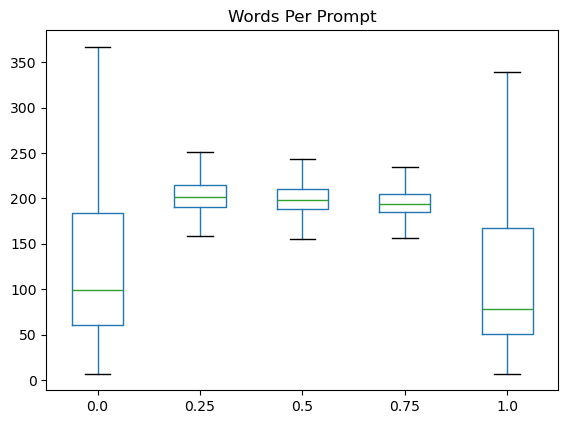

In [14]:
train_df['Words Per Prompt'] = train_df['prompt'].str.split().apply(len)
train_df.boxplot('Words Per Prompt', by='score', grid=False, showfliers=False)
plt.suptitle("")
plt.xlabel("")
plt.show()


In [15]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [44]:
from sklearn import preprocessing

score_encoder = preprocessing.LabelEncoder()
train_df['label'] = score_encoder.fit_transform(train_df['score'].tolist()) # Turns 0, 0.25, 0.5, 0.75, 1 into 0, 1, 2, 3, 4
test_df['label'] = score_encoder.fit_transform(test_df['score'].tolist())

In [49]:
import re

class TextCleaner():
    def __init__(self):
        pass
    
    def clean_text(self, text):
        text = text.lower()
        text = re.sub(r'<.*?>', '', text)
        text = re.sub(r'http\S+', '', text)
        text = re.sub(r"[^a-zA-Z0-9\s\n]", "", text)
        text = re.sub(r"\s+", " ", text).strip()
        return text

cleaner = TextCleaner()
train_df['cleaned_text'] = train_df['prompt'].apply(cleaner.clean_text)
test_df['cleaned_text'] = test_df['prompt'].apply(cleaner.clean_text)

In [51]:
from datasets import Dataset
from transformers import AutoTokenizer

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Convert datasets to tokenized format
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

def tokenize_data(examples):
    return tokenizer(examples["cleaned_text"], truncation=True)

tokenized_train = train_dataset.map(tokenize_data, batched=True)
tokenized_test = test_dataset.map(tokenize_data, batched=True)

Map:   0%|          | 0/24964 [00:00<?, ? examples/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Map: 100%|██████████| 10699/10699 [00:00<00:00, 13795.21 examples/s]


In [60]:
tokenized_train = tokenized_train.remove_columns([col for col in tokenized_train.column_names if col not in ['label', 'input_ids', 'attention_mask']])
tokenized_test = tokenized_test.remove_columns([col for col in tokenized_test.column_names if col not in ['label', 'input_ids', 'attention_mask']])

In [62]:
import torch
import torch.nn as nn
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [65]:
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification
        .from_pretrained(model_ckpt, num_labels=num_labels)
        .to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [66]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [67]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(tokenized_train) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"

training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    log_level="error",
    report_to="none"
)

/Users/lichu/anaconda3/envs/cs224n/lib/python3.12/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [68]:
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
)

trainer.train()

  0%|          | 2/782 [00:18<2:17:20, 10.57s/it]

KeyboardInterrupt: 